This notebook demonstrates how to create an offset dictionary from IV sweep data.

It was created in May 2023 by Roger Romani, some functions may have changed since then. Feel free to reach out with questions.

In [2]:
import time as tm
import pickle
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.fftpack import fft, ifft, fftfreq
mpl.rcParams['figure.figsize'] = [10, 6.5]

import numpy as np

from pytesdaq.io.hdf5 import H5Reader
from pytesdaq.processing import process_ivsweep, IVanalysis
from pytesdaq.processing import _iv_didv_tools_plotting as plot


rsh = 5e-3
fs = 1.25e6

/home/roger/.local/lib/python3.6/site-packages/paramiko/transport.py:32: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.backends import default_backend
/usr/lib64/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/roger/.local/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


We have made a calibration dictionary that allows you to look up and correct for nonlinearities in the FEB output offset. Let's load it in below.

In [3]:
save_dict_name = 'offset_cal_dict_d_022124.pickle'
with open(save_dict_name, 'rb') as handle:
    offsets_cal_d = pickle.load(handle)

We'll now specify where to look for our sweep data that we're basing the offset measurement off of.

In [5]:
IV_dIdV_sweep_folder = '/sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506'
chans = ['Melange025pcRight']
channel_num = 0

In [6]:
# create an object of the H5Reader class 
h5read = H5Reader() 

# get the start time so we know the total time 
start_time = tm.time()

# get the dataframe for the processed raw data
df = []
df = process_ivsweep(
    ivfilepath=IV_dIdV_sweep_folder,
    chans=chans,
    lgcverbose=True, # Switch to True to know which file its on
    lgcsave=False,
)
# get the end time 
end_time = tm.time()

print(f'IV sweep took {(end_time - start_time)/60: .3f} min to process')

#need to flip the QET bias for all the Pyle lab data
df.qetbias*= -1 

#convert the dataframe into a IV object that we can work with
IVobj = IVanalysis(
    df, 
    rshunt = 5e-3,
    nnorm=5, # number of points in normal region
    nsc=3, # number of points in superconducting region
    lgcremove_badseries = False
)

IVobj.rshunt_err = 0.1e-3


Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/didv_I2_D20230626_T235701_F0001.hdf5

Processing channel Melange025pcRight (ndarray index = 0)
----
dIdV processing
----

Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/didv_I2_D20230627_T000351_F0001.hdf5

Processing channel Melange025pcRight (ndarray index = 0)
----
dIdV processing
----

Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/didv_I2_D20230627_T001042_F0001.hdf5

Processing channel Melange025pcRight (ndarray index = 0)
----
dIdV processing
----

Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/didv_I2_D20230627_T001733_F0001.hdf5

Processing channel Melange025pcRight (ndarray index = 0)
----
dIdV processing
----

Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/didv_I2_D20230627_T002423_F0001.hdf5

Processing channel Melange025pcRight (ndarray index = 0)
----
dIdV processing
----

Processing dumps in: /sd

Processing channel Melange025pcRight (ndarray index = 0)
----
IV processing
----

Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/iv_I2_D20230627_T001614_F0001.hdf5

Processing channel Melange025pcRight (ndarray index = 0)
----
IV processing
----

Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/iv_I2_D20230627_T002304_F0001.hdf5

Processing channel Melange025pcRight (ndarray index = 0)
----
IV processing
----

Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/iv_I2_D20230627_T002953_F0001.hdf5

Processing channel Melange025pcRight (ndarray index = 0)
----
IV processing
----

Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/iv_I2_D20230627_T003643_F0001.hdf5

Processing channel Melange025pcRight (ndarray index = 0)
----
IV processing
----

Processing dumps in: /sdata1/runs/run28/raw/iv_didv_I2_D20230626_T235506/iv_I2_D20230627_T004335_F0001.hdf5

Processing channel Melange025pcRight (ndarray

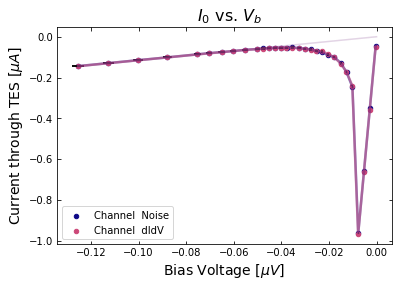

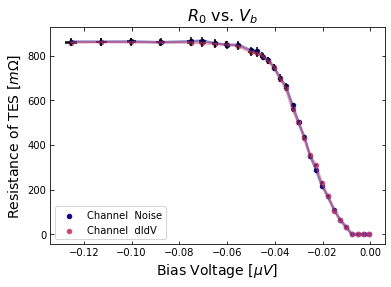

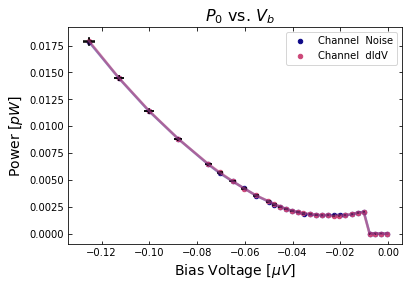

In [7]:
#make a few plots to ensure all is well
IVobj.analyze_sweep(lgcplot = True)

Now we can calculate the offset dictuonary. For lack of confusion, this dict includes the offset output calibration dictionary as part of it.

In [8]:
#read in 2 events to get the metadata
didvfilepath = sorted(glob(IV_dIdV_sweep_folder + '/didv_*'))[0]
traces_temp, metadata = h5read.read_many_events(filepath = didvfilepath,
    nevents=2,
    output_format=2,
    detector_chans=chans,
    include_metadata=True,
    adctoamp = True
)

#generate the offset dictionary
offset_dict = IVobj.get_offsets_dict(metadata, chans[channel_num], lgc_sweepbias_flipped=True,
                                     #lgc_calibrated_offsets=True, 
                                     calibration_dict=offsets_cal_d)

print(metadata[0]['detector_config'][chans[0]]['output_offset'])
print(offset_dict)

Using calibrated offsets approach
Using uncalibrated offsets approach
-0.11843712
{'i0_off': -1.2185909072149633e-07, 'i0_off_err': 9.902599612646083e-11, 'ibias_off': -4.6867115050777804e-08, 'ibias_off_err': 1.688186664902133e-10, 'i0_changable_offset_cal': -8.659477502346777e-06, 'i0_changable_offset_uncal': -9.474969e-06, 'output_offset': -0.11843712, 'rp': 0.0029897958005607487, 'IVobj': <pytesdaq.processing._iv_didv_tools.IVanalysis object at 0x7f71792486a0>, 'calibration_dict': {'model': 'lookup_extrapolated', 'params': {'params_low': array([7.86747980e-05, 6.58538898e-07]), 'params_high': array([7.84288051e-05, 7.66876272e-07]), 'lookup_x': array([-0.13797314, -0.13553114, -0.13308913, -0.13064713, -0.12820513,
       -0.12576313, -0.12332112, -0.12087912, -0.11843712, -0.11599512,
       -0.11355311, -0.11111111, -0.10866911, -0.10622711, -0.1037851 ,
       -0.1013431 , -0.0989011 , -0.0964591 , -0.09401709, -0.09157509,
       -0.08913309, -0.08669109, -0.08424908, -0.081807

Finally, we save the offset dictionary we just created

In [8]:
#save the offset dictionary
rq_files_path = '/sdata1/runs/run28/RQFiles/'
save_dict_name = 'offsets_' + str(chans[channel_num]) + "_7b"
print("Save as: " + save_dict_name)

with open(rq_files_path + save_dict_name, 'wb') as handle:
    pickle.dump(offset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Save as: offsets_Melange025pcRight_7b
